# Accelerating AIA Time Lag Analysis with Cupy and Dask

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import sys
import os
import yaml
import pathlib
import glob

import numpy as np
import cupy
import matplotlib.pyplot as plt
import dask
import dask.array as da
import distributed
import astropy.units as u
import astropy.time
import sunpy.map
from sunpy.net import Fido,attrs
import ndcube
from astropy.visualization import ImageNormalize,SqrtStretch

import aiacube
from aiacube.prep import register_and_derotate

%matplotlib inline

## Querying Data

In [22]:
t_start = astropy.time.Time('2010-09-29T13:00:00')
q = Fido.search(
    attrs.Time(t_start, t_start + 1*u.minute),
    attrs.Instrument.aia,
    attrs.Physobs.intensity,
    attrs.Wavelength(171*u.angstrom) | attrs.Wavelength(94*u.angstrom),
)

In [23]:
q

T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str20,str7,str5,int64,int64
2010-09-29T13:00:02Z,SDO/AIA,AIA_3,171,2101
2010-09-29T13:00:14Z,SDO/AIA,AIA_3,171,2101
2010-09-29T13:00:26Z,SDO/AIA,AIA_3,171,2101
2010-09-29T13:00:38Z,SDO/AIA,AIA_3,171,2101
2010-09-29T13:00:50Z,SDO/AIA,AIA_3,171,2101
2010-09-29T13:01:02Z,SDO/AIA,AIA_3,171,2101
T_REC,TELESCOP,INSTRUME,WAVELNTH,CAR_ROT
str20,str7,str5,int64,int64
2010-09-29T13:00:02Z,SDO/AIA,AIA_4,94,2101


In [ ]:
files = Fido.fetch(q)

In [4]:
files = (sorted(glob.glob('/str-server/data/sdo/aia/level1/2010/09/29/0094/*.fits')) +
         sorted(glob.glob('/str-server/data/sdo/aia/level1/2010/09/29/0171/*.fits')))

## Creating Level 2 Data Cubes

Before we experiment with any GPUs, we need to prep the data and get it into our aligned stacks. There's also progress being made on accelerating these steps, but we'll leave this be for now.

First, setup a Dask cluster

In [2]:
client = distributed.Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:34001 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 36 Memory: 134.88 GB


Convert all the 94 and 171 maps to level 1.5 maps and derotate them to a common coordinate frame to create level 2 data cubes for 12 hours of observations.

In [5]:
maps = client.map(sunpy.map.Map, files, pure=True)

In [6]:
headers = client.map(lambda x: x.meta, maps, pure=True)

In [7]:
headers = client.gather(headers)

In [8]:
maps_94 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==94]

In [9]:
maps_171 = [m for (m,h) in zip(maps,headers) if h['wavelnth']==171]

In [10]:
maps_94_lvl_2 = register_and_derotate(maps_94)

In [11]:
maps_171_lvl_2 = register_and_derotate(maps_171)

Next, stack all of the maps into to create our level 2 data cubes for each channel

In [12]:
cube_94 = aiacube.AIACube.from_futures(maps_94_lvl_2)

In [13]:
cube_94

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  7.5930119093379e-20  0.0  
PC2_1 PC2_2 PC2_3  : 1.8352859215588e-19  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  11.98999999999941  
NAXIS : 4096  4096  25
---------------------
Length of NDCube: [  25. 4096. 4096.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [14]:
cube_94.data

dask.array<stack, shape=(25, 4096, 4096), dtype=float64, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

In [15]:
cube_171 = aiacube.AIACube.from_futures(maps_171_lvl_2)

In [16]:
cube_171

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 2048.5  2048.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  -8.8881419185242e-20  0.0  
PC2_1 PC2_2 PC2_3  : -8.8881419185242e-20  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  12.00000000000188  
NAXIS : 4096  4096  25
---------------------
Length of NDCube: [  25. 4096. 4096.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [17]:
cube_171.data

dask.array<stack, shape=(25, 4096, 4096), dtype=float64, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>

We are only computing the timelags for a single active region so we'll crop our full-disk images.

In [27]:
subcube_94 = cube_94.crop_by_coords(
    lower_corner=(0*u.s, 0*u.arcsec, 150*u.arcsec),
    upper_corner=(12*u.h+12*u.s, 450*u.arcsec, 600*u.arcsec)
)

In [28]:
subcube_171 = cube_171.crop_by_coords(
    lower_corner=(0*u.s, 0*u.arcsec, 150*u.arcsec),
    upper_corner=(12*u.h+12*u.s, 450*u.arcsec, 600*u.arcsec)
)

If we inspect the resulting data cube, we can confirm that we've cropped it a smaller region.

In [29]:
subcube_94

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'TIME'  
CRVAL : 0.0  0.0  0.0  
CRPIX : -248.5  1.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  7.5930119093379e-20  0.0  
PC2_1 PC2_2 PC2_3  : 1.8352859215588e-19  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.00016666666666667  0.00016666666666667  11.98999999999941  
NAXIS : 752  752  25
---------------------
Length of NDCube: [ 25. 752. 752.] pix
Axis Types of NDCube: ('time', 'custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon')

In [30]:
subcube_94.data

dask.array<getitem, shape=(25, 752, 752), dtype=float64, chunksize=(1, 752, 752), chunktype=numpy.ndarray>

<WCSAxesSubplot:xlabel='custom:pos.helioprojective.lon [deg]', ylabel='custom:pos.helioprojective.lat [deg]'>

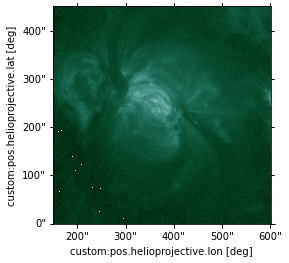

In [34]:
subcube_94[0,:,:].plot(
    cmap='sdoaia94',
    norm=ImageNormalize(vmin=0,vmax=5e1,stretch=SqrtStretch())
)

## Saving and Restoring Data Cubes

As we want to perform our analysis on these cutout level 2 data cubes for our two channels, we do not want to go through this whole prep procedure again. We can save this higher level data product as a `zarr` dataset.

In [30]:
subcube_94.to_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2')

In [31]:
subcube_171.to_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2')

We can then read these datasets back in later without having to go through the rather expensive and time consuming computations above.

In [4]:
subcube_94 = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2', 94*u.angstrom)

In [5]:
subcube_171 = aiacube.AIACube.from_zarr('/nobackup/wtbarnes/time_lag/noaa_11109/aia_level_2', 171*u.angstrom)

## Time Lag

Investigate four possible scenarios:
* Numpy
* Dask
* Cupy
* Dask+cupy

Now, we want to use our level 2 data cubes to calculate the time lag between the 94 and 171 channels in AR NOAA 11109

First, we need to rechunk the data such that we have a single chunk along the time axis.

In [35]:
subcube_94_rechunk = subcube_94.rechunk(subcube_94.data.shape[:1] + (50, 50))

In [36]:
subcube_171_rechunk = subcube_171.rechunk(subcube_171.data.shape[:1] + (50, 50))

### Numpy

In [45]:
def cc_numpy():
    ...

First, pull arrays into memory (this will be impractical for very large cubes)

### Cupy

In [47]:
def cc_cupy():
    # Move arrays to the GPU
    ...

### Dask + Numpy

Next,  we can use the `time_lag_map` and `peak_correlation_map` functions to compute the time lag and maximum cross-correlation in each pixel over the entire 12-hour window.

In [37]:
tl_map = aiacube.time_lag_map(
    subcube_94_rechunk,
    subcube_171_rechunk,
    #timelag_bounds=(-3*u.h, 3*u.h),
)

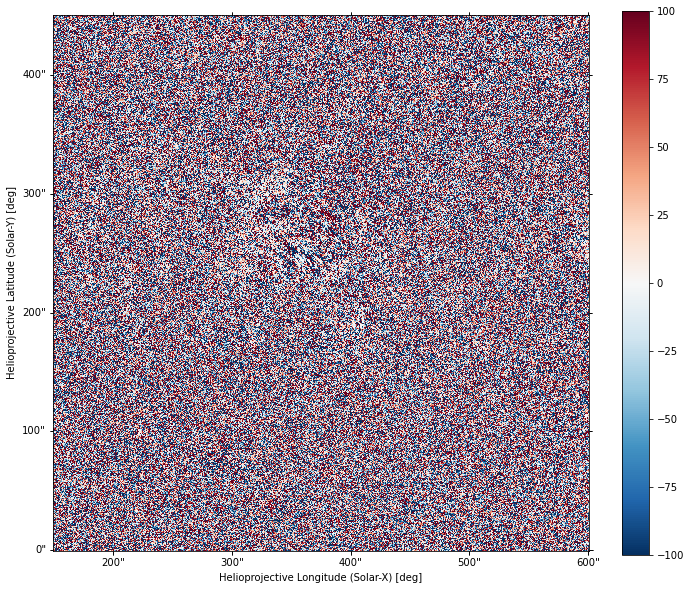

In [41]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=tl_map)
im = tl_map.plot(
    axes=ax,
    vmin=-(1e2*u.s).to(u.s).value,
    vmax=(1e2*u.s).to(u.s).value,
    #cmap='idl_bgry_004',
    title=False
)
ax.grid(alpha=0)
fig.colorbar(im)

In [43]:
maxcc_map = aiacube.peak_cross_correlation_map(
    subcube_94_rechunk,
    subcube_171_rechunk,
    #timelag_bounds=(-3*u.h, 3*u.h),
)

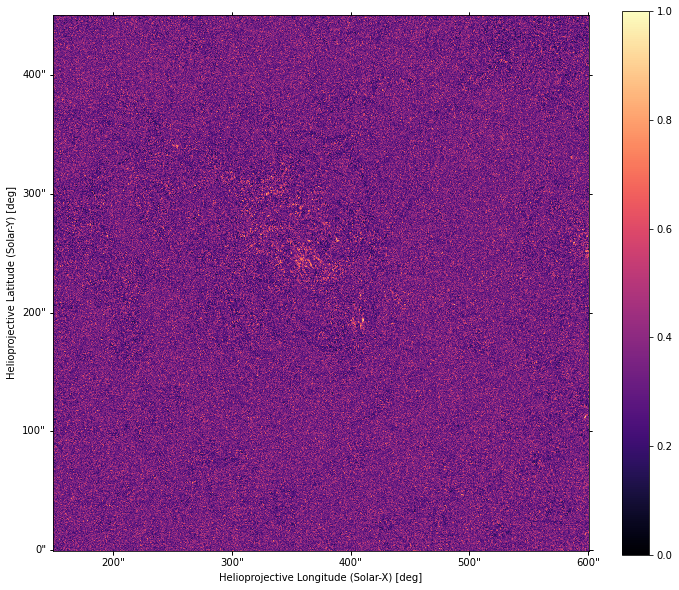

In [44]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=maxcc_map)
im = maxcc_map.plot(
    axes=ax,
    vmin=0,
    vmax=1,
    cmap='magma',
    title=False
)
ax.grid(alpha=0)
fig.colorbar(im)

### Dask+cupy

* This needs a system with multiple GPUs
* Need to investigate `dask-cuda` further

## Summarize Benchmarks